In [1]:
#For use in Google drive
from google.colab import drive
drive.mount('/content/drive')
tweetPath = "/content/drive/MyDrive/Codes/Twitter Data"


ModuleNotFoundError: No module named 'google'

In [2]:
#For running locally
tweetPath = "Twitter Data"
stockPath = "Stock_Max"

In [77]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from functools import reduce
from IPython.display import display
import nltk
nltk.download('vader_lexicon')
from tqdm import tqdm
from scipy.stats import pearsonr
tqdm.pandas()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liche\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

In [151]:
tweets = pd.read_csv('processed_dataframe.csv',index_col=0)
tweets_exclRT = tweets[~tweets['post'].str.contains("RT").astype(bool)].reset_index(drop=True)

prices = reduce(lambda x,y:x.merge(y,how="outer", left_index=True,right_index=True),\
[pd.read_csv(os.path.join(stockPath,filename)).loc[:,["Date","Adj Close"]]\
.set_index('Date').set_axis([filename[:-4]], axis=1) for filename in os.listdir(stockPath)]).pct_change()

long_prices = pd.melt(prices,ignore_index=False,var_name="ticker",value_name="adj. close")\
    .reset_index().rename({'Date':'date'},axis=1).groupby(['ticker','date']).sum()


MultiIndex([('AAPL', '1980-12-12'),
            ('AAPL', '1980-12-15'),
            ('AAPL', '1980-12-16'),
            ('AAPL', '1980-12-17'),
            ('AAPL', '1980-12-18'),
            ('AAPL', '1980-12-19'),
            ('AAPL', '1980-12-22'),
            ('AAPL', '1980-12-23'),
            ('AAPL', '1980-12-24'),
            ('AAPL', '1980-12-26'),
            ...
            ( 'VIX', '2021-10-28'),
            ( 'VIX', '2021-10-29'),
            ( 'VIX', '2021-11-01'),
            ( 'VIX', '2021-11-02'),
            ( 'VIX', '2021-11-03'),
            ( 'VIX', '2021-11-04'),
            ( 'VIX', '2021-11-05'),
            ( 'VIX', '2021-11-08'),
            ( 'VIX', '2021-11-09'),
            ( 'VIX', '2021-11-10')],
           names=['ticker', 'date'], length=92853)

In [146]:
long_prices

adj. close
ticker date                  
AAPL   1980-12-12    0.000000
       1980-12-15   -0.052164
       1980-12-16   -0.073404
       1980-12-17    0.024755
       1980-12-18    0.028991
...                       ...
VIX    2021-11-04    0.022517
       2021-11-05    0.067358
       2021-11-08    0.044903
       2021-11-09    0.032520
       2021-11-10    0.053431

[92853 rows x 1 columns]

Raw Tweets

ticker
AAPL    AxesSubplot(0.125,0.125;0.775x0.755)
AMZN    AxesSubplot(0.125,0.125;0.775x0.755)
FB      AxesSubplot(0.125,0.125;0.775x0.755)
GOOG    AxesSubplot(0.125,0.125;0.775x0.755)
NFLX    AxesSubplot(0.125,0.125;0.775x0.755)
TSLA    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

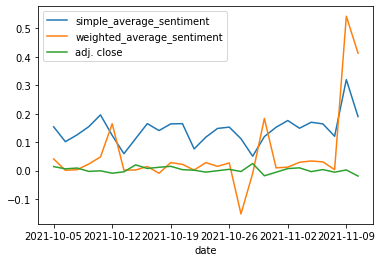

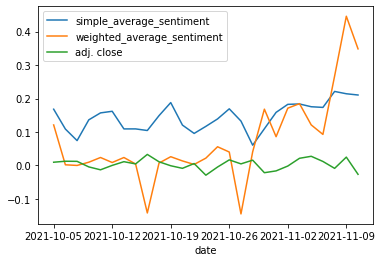

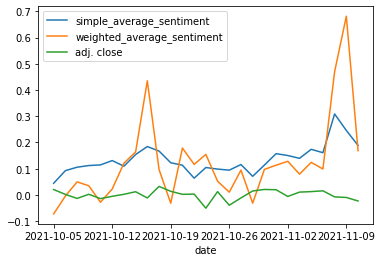

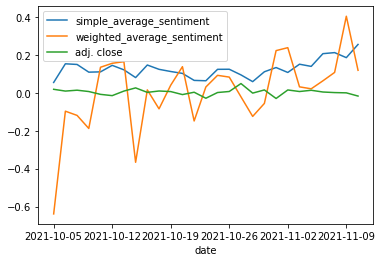

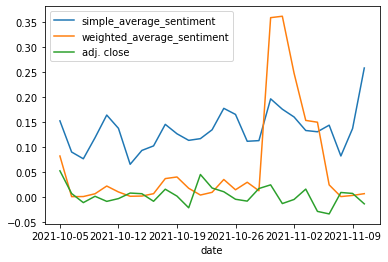

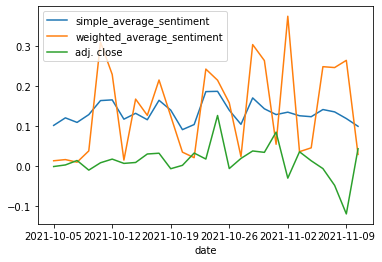

In [198]:
tweets['weighted_sentiment'] = tweets['sentiment'] *(tweets['retweets'] + tweets['favorites'])
grouped_sum = tweets.groupby(['ticker','date']).sum()
simpleAverageSentiment = tweets.groupby(['ticker','date']).mean()['sentiment'].to_frame()\
    .set_axis(['simple_average_sentiment'],axis=1)
weightedAverageSentiment = (grouped_sum['weighted_sentiment']/\
    (grouped_sum['retweets'] + grouped_sum['favorites']))\
        .to_frame().set_axis(['weighted_average_sentiment'],axis=1)

sentimentPrice = simpleAverageSentiment.merge(weightedAverageSentiment,left_index=True,right_index=True)\
    .merge(long_prices, left_index=True,right_index=True)
    
sentimentPrice.groupby(level=0).apply(lambda k:k.reset_index().set_index('date').plot())


Excluded Retweets

ticker
AAPL    AxesSubplot(0.125,0.125;0.775x0.755)
AMZN    AxesSubplot(0.125,0.125;0.775x0.755)
FB      AxesSubplot(0.125,0.125;0.775x0.755)
GOOG    AxesSubplot(0.125,0.125;0.775x0.755)
NFLX    AxesSubplot(0.125,0.125;0.775x0.755)
TSLA    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

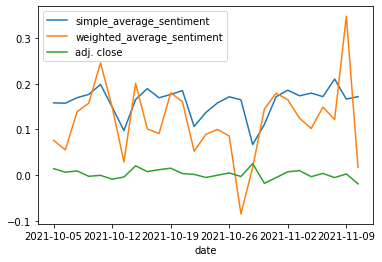

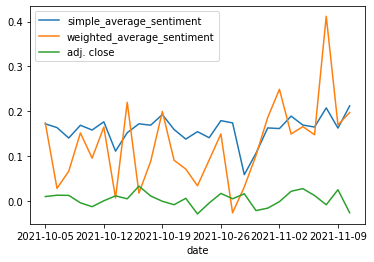

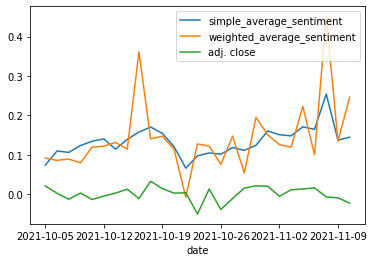

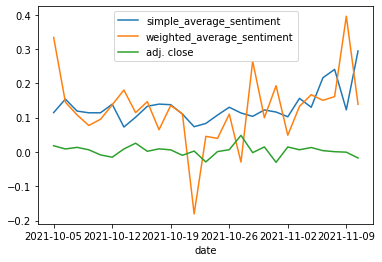

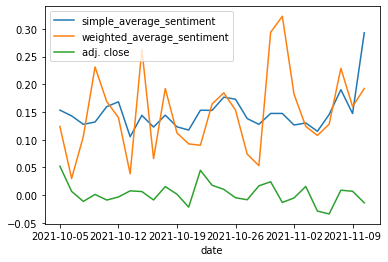

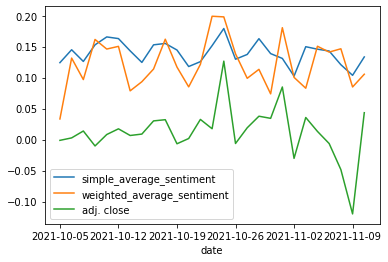

In [199]:
tweets_exclRT['weighted_sentiment'] = tweets_exclRT['sentiment'] *(tweets_exclRT['retweets'] + tweets_exclRT['favorites'])
grouped_sum = tweets_exclRT.groupby(['ticker','date']).sum()
simpleAverageSentiment = tweets_exclRT.groupby(['ticker','date']).mean()['sentiment'].to_frame()\
    .set_axis(['simple_average_sentiment'],axis=1)
weightedAverageSentiment = (grouped_sum['weighted_sentiment']/\
    (grouped_sum['retweets'] + grouped_sum['favorites']))\
        .to_frame().set_axis(['weighted_average_sentiment'],axis=1)

sentimentPrice = simpleAverageSentiment.merge(weightedAverageSentiment,left_index=True,right_index=True)\
    .merge(long_prices, left_index=True,right_index=True)
    
sentimentPrice.groupby(level=0).apply(lambda k:k.reset_index().set_index('date').plot())

In [200]:
def f(x):
    d={}
    d['simple correlation coeff.'] = pearsonr(x['simple_average_sentiment'], x['adj. close'])[0]
    d['simple correlation p-value'] = pearsonr(x['simple_average_sentiment'], x['adj. close'])[1]
    d['weighted correlation coeff.'] = pearsonr(x['weighted_average_sentiment'], x['adj. close'])[0]
    d['weighted correlation p-value'] = pearsonr(x['weighted_average_sentiment'], x['adj. close'])[1]
    return pd.Series(d, index=['simple correlation coeff.', 'simple correlation p-value','weighted correlation coeff.', 'weighted correlation p-value'])
sentimentPrice.groupby(level=0).apply(f)

,simple correlation coeff.,simple correlation p-value,weighted correlation coeff.,weighted correlation p-value
ticker,,,,
AAPL,-0.064394,0.749653,0.074928,0.710313
AMZN,-0.075163,0.709441,-0.193338,0.333927
FB,0.154313,0.442184,-0.113230,0.573888
GOOG,-0.165787,0.408557,-0.142934,0.476944
NFLX,0.008503,0.966424,0.012897,0.949091
TSLA,0.608960,0.000749,0.360100,0.065031


In [83]:
#Shouldn't be ran unless there are changes to twitter data source
#Use tweets = pd.read_csv('processed.csv') instead
tweets = pd.concat([pd.read_csv(os.path.join(tweetPath, filename),index_col=0)
.assign(ticker=filename[:-4].split("_")[2],date=filename[:-4].split("_")[3])\
for filename in os.listdir(tweetPath) if filename.endswith(".csv")])

tweets = tweets[tweets['post'].apply(lambda x:isinstance(x, str))]\
.drop(tweets[tweets['date'].apply(len)<2].index).reset_index(drop=True)

sia = SentimentIntensityAnalyzer()
tweets['sentiment'] = tweets['post'].progress_apply(lambda x:sia.polarity_scores(x)['compound'])
tweets['datetime'] = tweets['datetime'].apply(lambda x:x[:10])
tweets.rename({'datetime':'date'},inplace=True,axis=1)
tweets.to_csv('processed_dataframe.csv')

100%|██████████| 686526/686526 [03:42<00:00, 3085.56it/s]


PermissionError: [Errno 13] Permission denied: 'processed_dataframe.csv'